In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
from summer2 import CompartmentalModel
from summer2.parameters import Parameter

**Model 1: Simple SIR**

In [23]:
def build_model():
    m = CompartmentalModel([0,100], ["S","E","I","Q","R"],"I",ref_date=datetime(2020,6,1))
    m.set_initial_population({"S": 13781001.0, "E": 832.0 , "I": 1153.0, "Q": 3622.0, "R": 14178.0})
    m.add_infection_frequency_flow("infection", Parameter("contact_rate"),"S","E") 
    m.add_transition_flow("progression", 0.2,"E","I")
    m.add_transition_flow("notification", Parameter("detection_rate"),"I","Q")
    m.add_transition_flow("recovery_from_Q", 0.0714,"Q","R") 
    m.add_transition_flow("recovery__from_I", 0.0714,"I","R") 
    m.request_output_for_flow("infection", "infection")
    m.request_output_for_flow("notification", "notification")
    m.request_output_for_compartments(name="active", compartments=["Q"])
    return m

In [24]:
m = build_model()

In [29]:
parameters = {"contact_rate": 0.9, "detection_rate": 0.5}

In [30]:
m.run(parameters)

<Axes: >

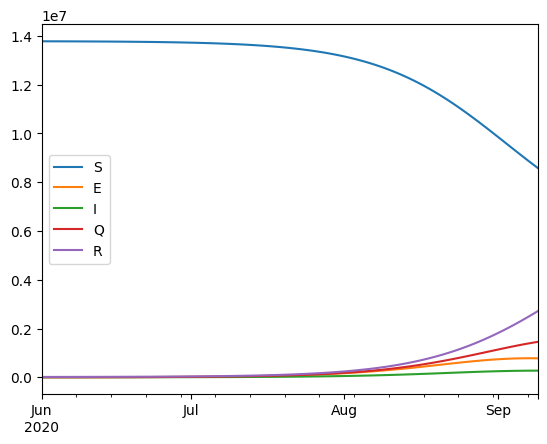

In [31]:
m.get_outputs_df().plot()

<Axes: >

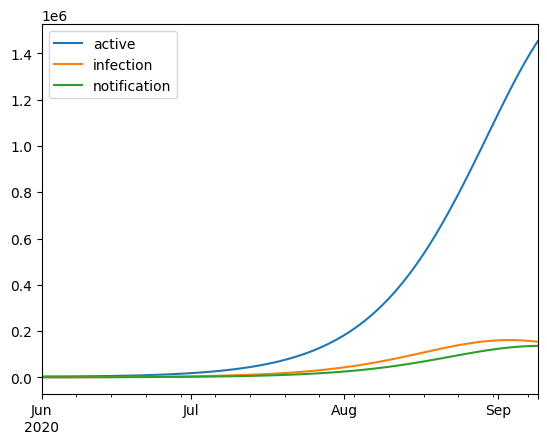

In [32]:
m.get_derived_outputs_df().plot()

In [161]:
df=pd.read_excel(io='InfectionsData_060120_093020.xlsx',index_col=0)
notification_data = df["INFECTIONS"]

<Axes: xlabel='DATE'>

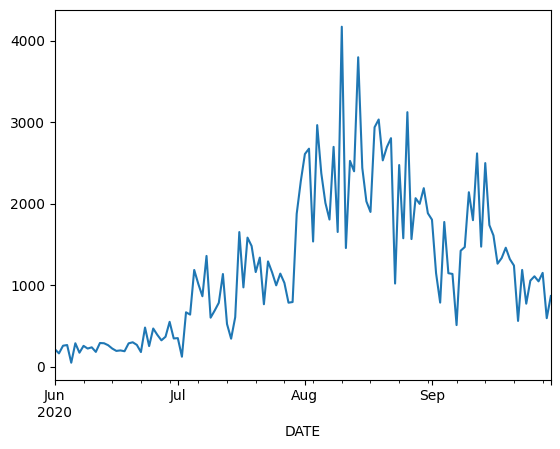

In [162]:
notification_data.plot()

In [163]:
notification_data_cal = notification_data[:61]

<Axes: xlabel='DATE'>

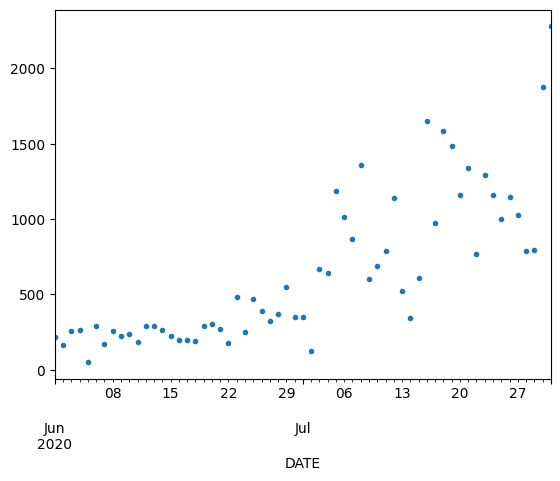

In [164]:
notification_data_cal.plot(style='.')

**Calibration**

In [165]:
# Targets represent data we are trying to fit to
from estival import targets as est

# We specify parameters using (Bayesian) priors
from estival import priors as esp

# Finally we combine these with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel

In [166]:
targets = [
    est.NormalTarget("notification", notification_data_cal, np.std(notification_data_cal) * 0.1),
    #est.NormalTarget("active", active_data_cal, np.std(active_data_cal) * 0.1)
]

In [167]:
priors = [
    esp.UniformPrior("contact_rate", (0.1,0.7)),
    esp.UniformPrior("detection_rate", (0.1,0.5)),
]

In [168]:
defp = {"contact_rate": 0.4, "detection_rate":0.24}

In [169]:
bcm = BayesianCompartmentalModel(m, defp, priors, targets)
from estival.wrappers import pymc as epm
import pymc as pm

In [170]:
with pm.Model() as model:

    # This is all you need - a single call to use_model
    variables = epm.use_model(bcm)

    # The log-posterior value can also be output, but may incur additional overhead
    # Use jacobian=False to get the unwarped value (ie just the 'native' density of the priors
    # without transformation correction factors)
    # pm.Deterministic("logp", model.logp(jacobian=False))

    # Now call a sampler using the variables from use_model
    # In this case we use the Differential Evolution Metropolis sampler
    # See the PyMC docs for more details
    idata = pm.sample(step=[pm.DEMetropolis(variables)], draws=8000, tune=0,cores=4,chains=6)

Population sampling (6 chains)
DEMetropolis: [contact_rate, detection_rate]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 6 chains for 0 tune and 8_000 draw iterations (0 + 48_000 draws total) took 22 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Visualizing Outputs**

In [171]:
import arviz as az

In [172]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
contact_rate,0.462,0.102,0.277,0.631,0.017,0.012,28.0,11.0,1.16
detection_rate,0.286,0.097,0.109,0.445,0.017,0.012,28.0,12.0,1.15


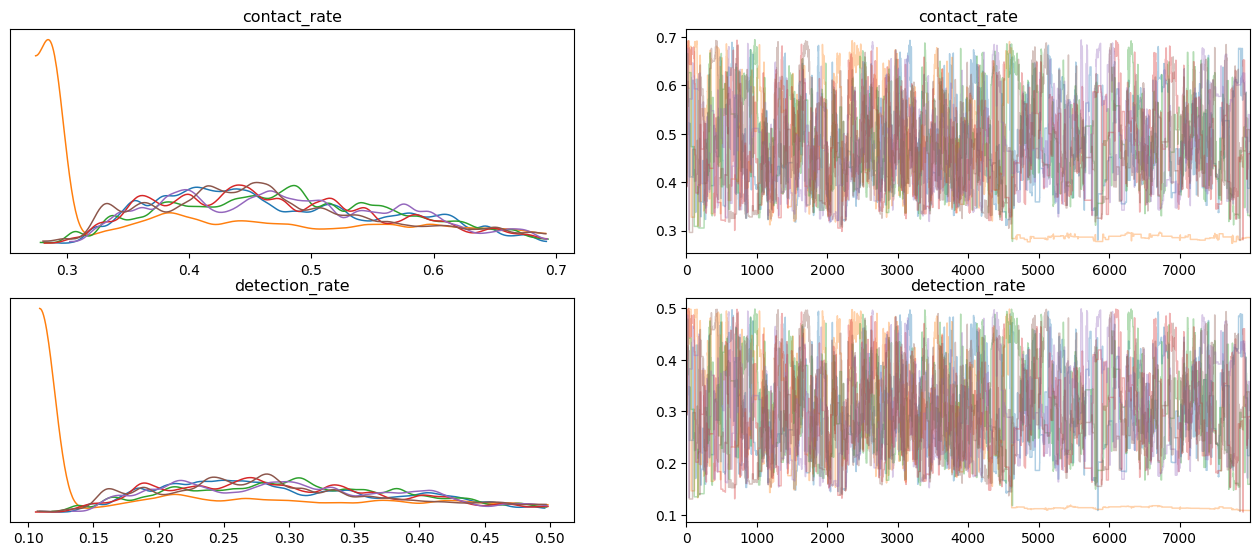

In [173]:
az.plot_trace(idata, figsize=(16,3.2*len(idata.posterior)),compact=False);#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

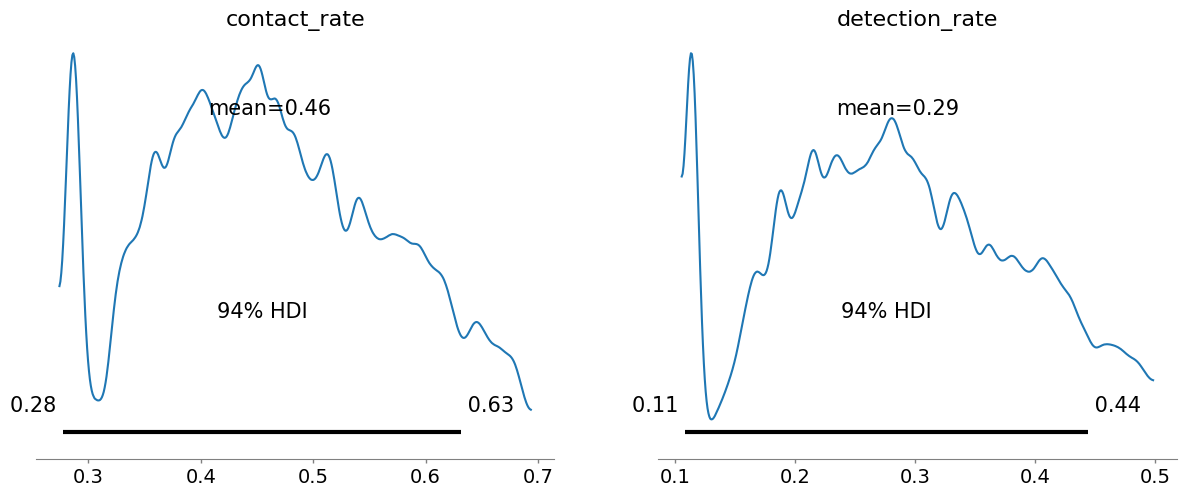

In [174]:
az.plot_posterior(idata);

**Obtaining Likelihood**

In [175]:
from estival.sampling.tools import likelihood_extras_for_idata

In [176]:
likelihood_df = likelihood_extras_for_idata(idata, bcm)

<Axes: xlabel='draw'>

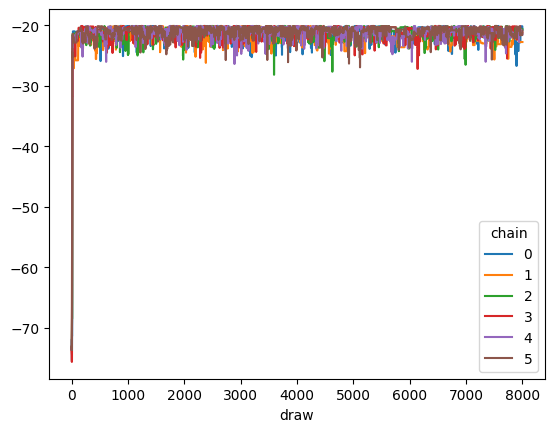

In [177]:
ldf_pivot = likelihood_df.reset_index(level="chain").pivot(columns=["chain"])

ldf_pivot["logposterior"].plot()

In [178]:
# Sort this DataFrame by logposterior to obtain the MAP index
ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)

# Extract the parameters from the calibration samples
map_params = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()

map_params

{'contact_rate': 0.40905459436923763, 'detection_rate': 0.23644162633786397}

In [179]:
bcm.loglikelihood(**map_params), ldf_sorted.iloc[0]["loglikelihood"]

(Array(-21.51886845, dtype=float64), -21.518868446387838)

In [180]:
map_res = bcm.run(map_params)

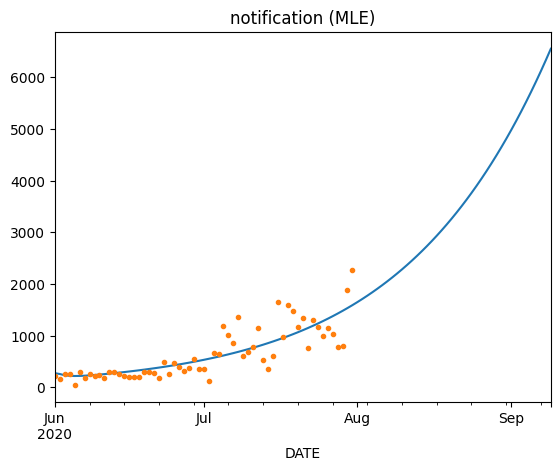

In [181]:
variable = "notification"

pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
bcm.targets[variable].data.plot(style='.');

**Compare with Actual Data for August 2020**

<Axes: title={'center': 'notification (MLE)'}, xlabel='DATE'>

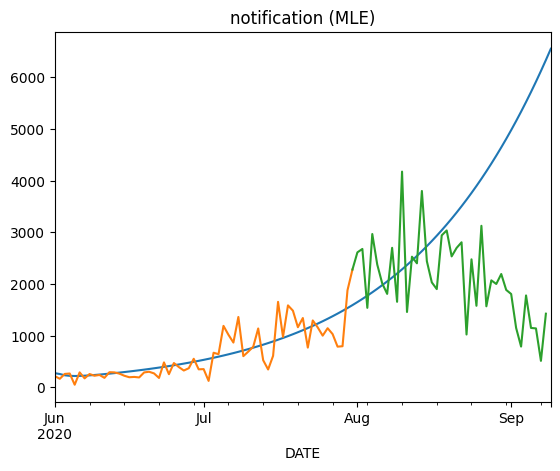

In [182]:
pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
notification_data[:61].plot()
notification_data[60:100].plot()

**Uncertainty Sampling**

In [183]:
sample_idata = az.extract(idata, num_samples = 400)
samples_df = sample_idata.to_dataframe().drop(columns=["chain","draw"])

In [184]:
from estival.utils.parallel import map_parallel

In [185]:
def run_sample(idx_sample):
    idx, params = idx_sample
    return idx, bcm.run(params)

In [186]:
sample_res = map_parallel(run_sample, samples_df.iterrows(), n_workers=4)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [187]:
import xarray as xr

In [188]:
xres = xr.DataArray(np.stack([r.derived_outputs for idx, r in sample_res]),
                    dims=["sample","time","variable"])
xres = xres.assign_coords(sample=sample_idata.coords["sample"],
                          time=map_res.derived_outputs.index, variable=map_res.derived_outputs.columns)

In [189]:
# Set some quantiles to calculate
quantiles = (0.01,0.05,0.25,0.5,0.75,0.95,0.99)

# Generate a new DataArray containing the quantiles
xquantiles = xres.quantile(quantiles,dim=["sample"])

In [190]:
# Extract these values to a pandas DataFrame for ease of plotting

uncertainty_df = xquantiles.to_dataframe(name="value").reset_index().set_index("time").pivot(columns=("variable","quantile"))["value"]

<Axes: title={'center': 'notification'}, xlabel='DATE'>

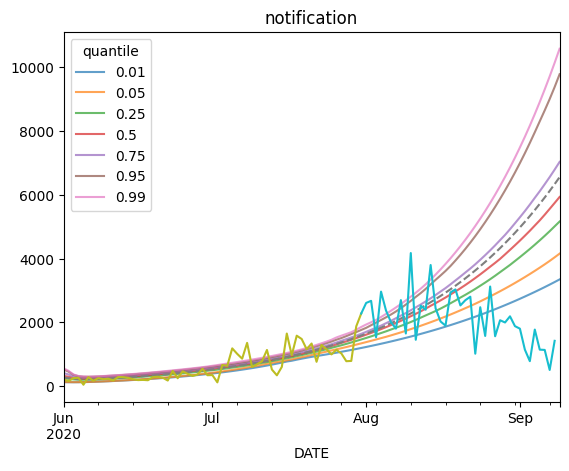

In [191]:
variable = "notification"

fig = uncertainty_df[variable].plot(title=variable,alpha=0.7)
pd.Series(map_res.derived_outputs[variable]).plot(style='--')
notification_data[:61].plot()
notification_data[60:100].plot()